In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from spikenet.network import Network
from spikenet.image_to_spike_convertor import ImageToSpikeConvertor, SpikePlotter
from IPython.display import HTML

splt = SpikePlotter()

In [2]:
class MyData(ImageToSpikeConvertor):
    RESIZE_SIZE = (16, 16)

    def __init__(self):
        super().__init__(
            train_data=torchvision.datasets.MNIST(
                root="./data",
                train=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
                download=True,
            ),
            test_data=torchvision.datasets.MNIST(
                root="./data",
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
            ),
        )

    def x_transform(self, x):
        x = super().x_transform(x)
        res = x.reshape(-1, self.time_scale, self.RESIZE_SIZE[0] * self.RESIZE_SIZE[1])
        return res

    def y_transform(self, y: torch.Any) -> torch.Any:
        y = super().y_transform(y)
        # to one hot
        y = torch.nn.functional.one_hot(y, num_classes=10).to(torch.float32)
        return y


data = MyData()
input_shape, output_shape = data.shape
data.describe()

shape:
  - x: torch.Size([16, 256])
  - y: torch.Size([10])
  - batch_size: 128


In [3]:
from spikenet.layers.spiking_dense import SpikingDenseLayer

class MyLayer(SpikingDenseLayer):

    def apply_time_reduction(
        self, x: torch.Tensor, mem_rec: torch.Tensor, norm
    ) -> torch.Tensor:
        output = torch.max(mem_rec, 1)[0] / (norm + 1e-8) - self.b
        return output

In [4]:
from spikenet.layers.spiking_dense import SpikingDenseLayer

net = (
    Network().add_layer(SpikingDenseLayer, 100, name="l1", input_dim=input_shape[1])
    .add_layer(SpikingDenseLayer, 100, name="l1a")
    # .add_layer(SpikingDenseLayer, 100, name="l1b")
    .add_layer(MyLayer, 10, name="l2", time_reduction="SpikeRate")
).build()

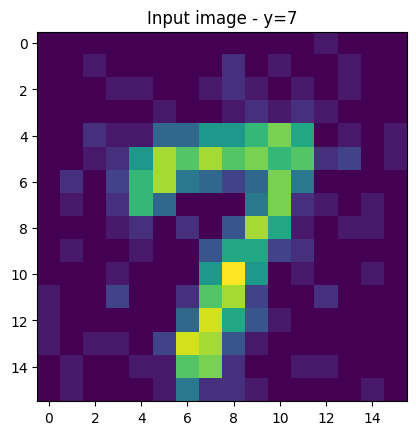

In [5]:
test_data = data.sample()
data_x, data_y = test_data

img = data_x.reshape([16, 16, 16])
img = img.sum(0)
plt.imshow(img)
data_class = torch.argmax(data_y)
plt.title(f"Input image - y={data_class}")
plt.show()

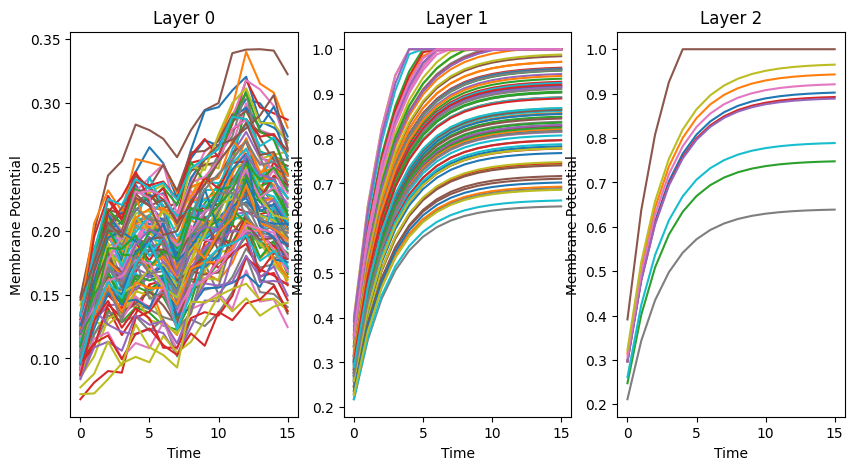

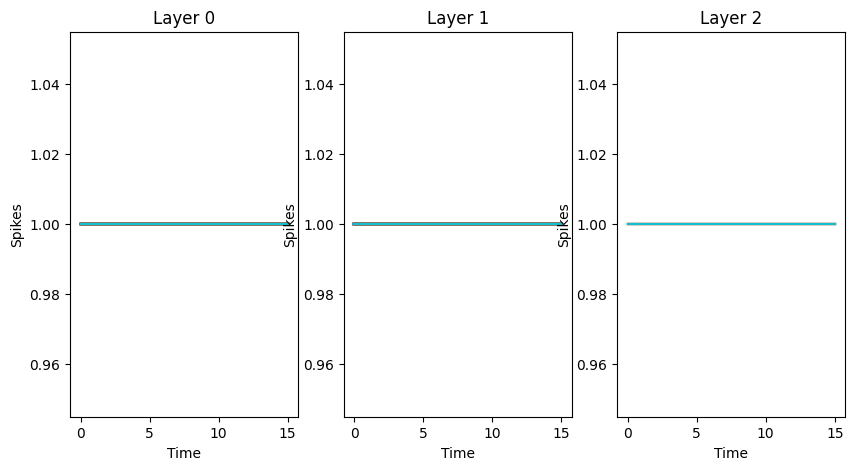

In [6]:
layer_res = list(net.forward_by_layer(data_x.reshape([1, *data_x.shape])))

num_layers = len(net.layers)
lyr: SpikingDenseLayer
fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
for i, lyr in enumerate(net.layers):
    lyr.plot_history(ax=axs[i], key="mem")
    axs[i].set_title(f"Layer {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Membrane Potential")
plt.show()

fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
for i, lyr in enumerate(net.layers):
    lyr.plot_history(ax=axs[i], key="spk")
    axs[i].set_title(f"Layer {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Spikes")
plt.show()

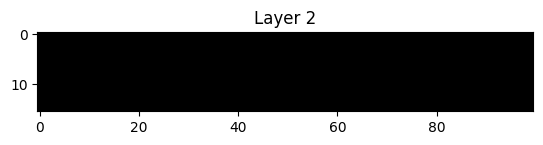

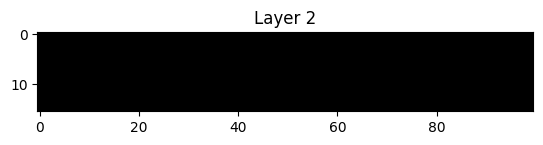

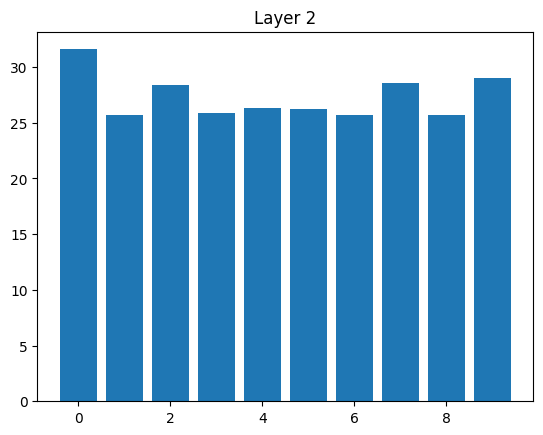

In [7]:
for res in layer_res:
    res = res[0, ...].detach().numpy()
    shp = res.shape
    if len(shp) == 2:
        plt.imshow(res, cmap="gray")
    elif len(shp) == 1:
        plt.bar(range(shp[0]), res)
    plt.title(f"Layer {i}")
    plt.show()


===== Training Started ======
Epoch 0 | ............................................... | Loss: 0.6554
Epoch 1 | ............................................... | Loss: 0.1864
Epoch 2 | ............................................... | Loss: 0.1165
Epoch 3 | ............................................... | Loss: 0.1010
Epoch 4 | ............................................... | Loss: 0.1119
Epoch 5 | ............................................... | Loss: 0.1005
Epoch 6 | ............................................... | Loss: 0.1076
Epoch 7 | ............................................... | Loss: 0.1005
Epoch 8 | ............................................... | Loss: 0.1051
Epoch 9 | ............................................... | Loss: 0.1002
===== Training Finished =====


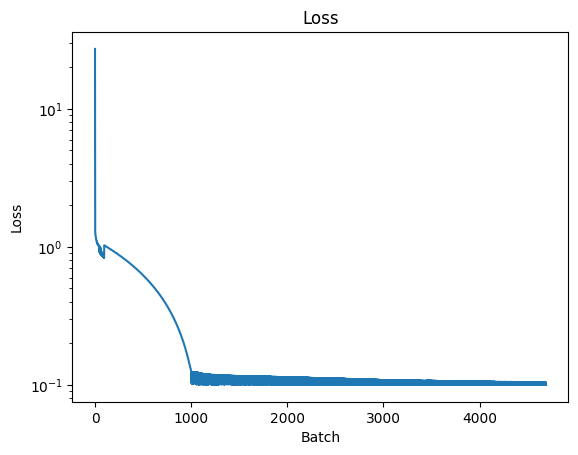

====== Testing Started ======
Accuracy: 980/10000 = 9.80%
===== Testing Finished ======


(10000, 980)

In [8]:
net.fit(data, epochs=10)

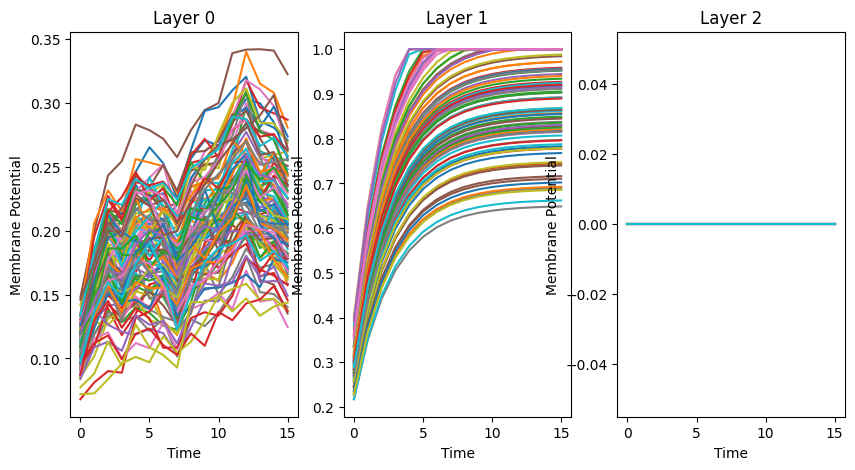

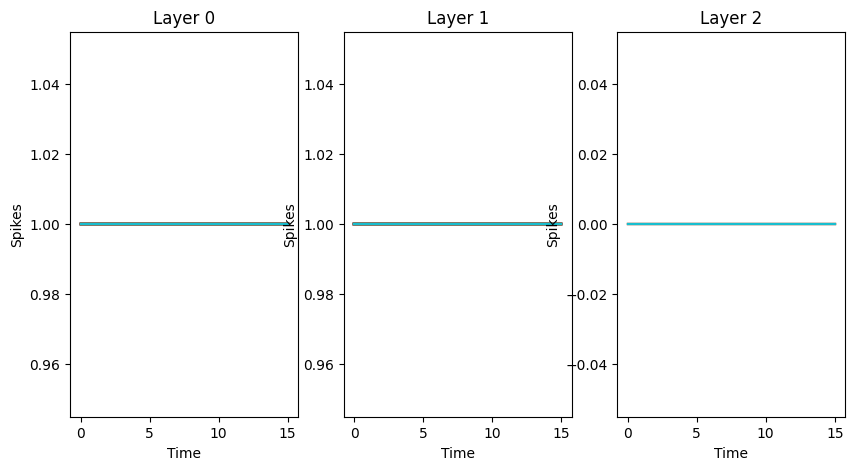

In [9]:
layer_res = list(net.forward_by_layer(data_x.reshape([1, *data_x.shape])))

num_layers = len(net.layers)
lyr: SpikingDenseLayer
fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
for i, lyr in enumerate(net.layers):
    lyr.plot_history(ax=axs[i], key="mem")
    axs[i].set_title(f"Layer {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Membrane Potential")
plt.show()

fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
for i, lyr in enumerate(net.layers):
    lyr.plot_history(ax=axs[i], key="spk")
    axs[i].set_title(f"Layer {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Spikes")
plt.show()

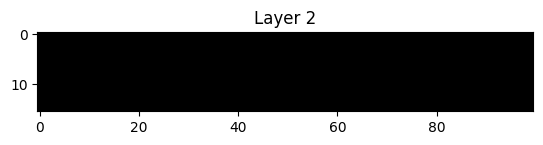

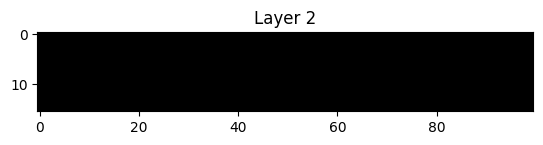

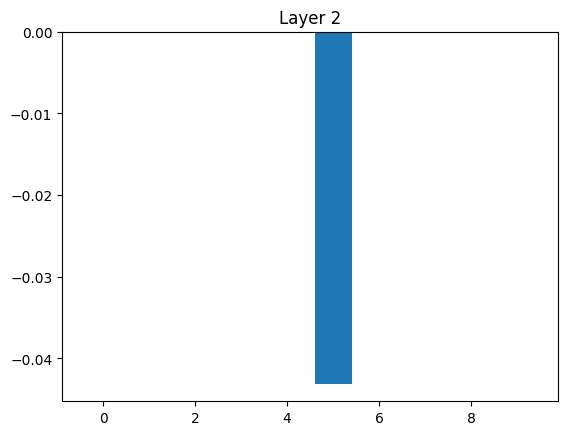

In [10]:
for res in layer_res:
    res = res[0, ...].detach().numpy()
    shp = res.shape
    if len(shp) == 2:
        plt.imshow(res, cmap="gray")
    elif len(shp) == 1:
        plt.bar(range(shp[0]), res)
    plt.title(f"Layer {i}")
    plt.show()

In [11]:
lyr: SpikingDenseLayer
# fig, axs = plt.subplots(1, 5, figsize=(10, 5))
# for lyr in net.layers:
#     lyr.plot_snapshot(axs)
# plt.show()

# fig, axs = plt.subplots(1, 5, figsize=(10, 5))
# for lyr in net.layers:
#     lyr.plot_snapshot_diff(axs)
# plt.show()

lyr = net.layers[0]
lyr.all_snapshots()

{}

IndexError: index 2 is out of bounds for axis 0 with size 2

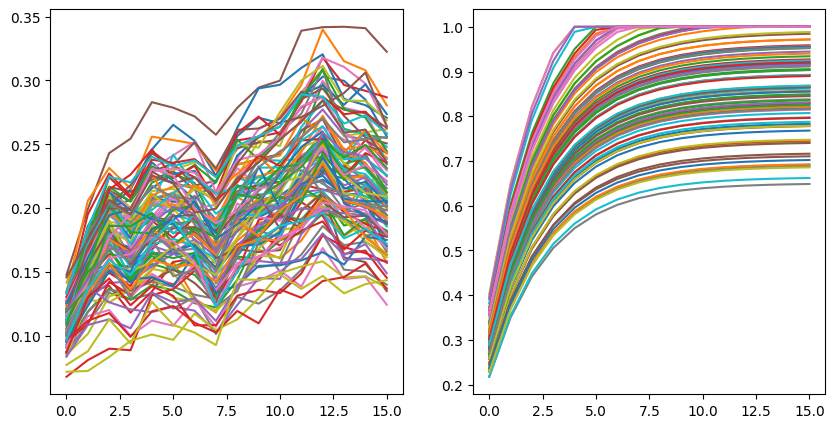

In [12]:
fix, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(len(net.layers)):
    net.layers[i].plot_history(axs[i])
plt.show()
# # mem = net.layers[0].get_history("mem")
# # mem.shape
# # res = splt.animate(mem)
# # HTML(res)

In [ ]:
# mem = net.layers[0].get_history("mem")
# plt.imshow(mem.reshape(-1, 100), cmap="gray")
# plt.xlabel("Neurons")
# plt.ylabel("Time")
# plt.show()

# for i in range(10):
#     plt.plot(mem[0, :, i], label=f"Neuron {i}")
# plt.xlabel("Time")
# plt.ylabel("Membrane Potential")
# plt.show()

In [ ]:
# mem = net.layers[1].get_history("mem")
# for i in range(10):
#     plt.plot(mem[0, :, i], label=f"Neuron {i}")
# # plt.plot(mem.reshape(-1, 10), cmap="gray")
# plt.xlabel("Neurons")
# plt.ylabel("Time")
# plt.show()

In [ ]:
# plt.imshow(net.layers[0].w.detach().numpy())
# plt.xlabel("Neurons")
# plt.ylabel("Input")
# plt.show()